In [1]:
import numpy as np
import pandas as pd
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
import os
import pandas as pd

## RAVDESS veri setinde numaraları duygulara eşleyen harita
label_map_ravdess = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', 
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

## RAVDESS veri setinin bulunduğu ana dizin
rav_path = "ravdess"  # Dizin yolunu kendi veri setine göre güncelle!

## Ses dosyalarının yolları ve duyguları saklayacağımız listeler
ravdess_file_paths = []
ravdess_labels = []

## Her aktör klasörünü oku
for actor in sorted(os.listdir(rav_path)):
    actor_path = os.path.join(rav_path, actor)
    
    ## Eğer bir klasörse işlem yap
    if os.path.isdir(actor_path):
        ## Aktörün içindeki tüm ses dosyalarını işle
        for file in sorted(os.listdir(actor_path)):
            if file.endswith(".wav"):  # Sadece .wav dosyalarını al
                file_path = os.path.join(actor_path, file)
                
                ## Dosya adından duygu indeksini al (örneğin '03-01-03-01-01-01-01.wav' → '03' duygusunu temsil eder)
                emotion_code = file[6:8]
                
                ## Etiket eşleme işlemi
                emotion = label_map_ravdess.get(emotion_code, "unknown")  # Geçersiz kod olursa 'unknown' ata
                
                ## Listeye ekle
                ravdess_labels.append(emotion)  # İlk sıraya Emotions
                ravdess_file_paths.append(file_path)  # İkinci sıraya Path

## Sonuçları bir CSV dosyasına kaydet (Emotions sütunu ilk, Path ikinci olacak şekilde)
df = pd.DataFrame({"Emotions": ravdess_labels, "Path": ravdess_file_paths})  
df.to_csv("ravdess_emotions.csv", index=False)

print("CSV dosyası oluşturuldu: ravdess_emotions.csv")


In [24]:
df=pd.read_csv("combined_dataset_cleaned.csv")

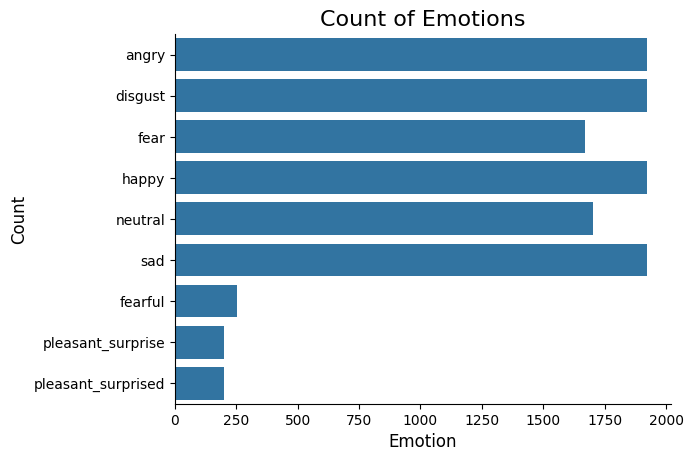

In [25]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotion', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [15]:
import os
import pandas as pd
import librosa
import numpy as np

def extract_features(file_path):
    """
    Verilen ses dosyasından özellik çıkarır.

    Args:
        file_path (str): Ses dosyasının yolu.

    Returns:
        np.ndarray: Özellikler içeren numpy dizisi.
    """
    try:
        # Ses dosyasını yükle
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Zero crossing rate
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)

        # Spectral özellikler
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        contrast_mean = np.mean(spectral_contrast, axis=1)  # Her bir bandın ortalaması
        contrast_std = np.std(spectral_contrast, axis=1)   # Her bir bandın standart sapması

        # Chroma STFT
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_stft_mean = np.mean(chroma_stft, axis=1)  # Her bir chroma kanalının ortalaması
        chroma_stft_std = np.std(chroma_stft, axis=1)    # Her bir chroma kanalının standart sapması

        # RMS enerji
        rms_mean = np.mean(librosa.feature.rms(y=audio))

        # Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        melspectrogram_mean = np.mean(mel_spectrogram)
        melspectrogram_std = np.std(mel_spectrogram)

        # Flatness (Düzlük)
        flatness_mean = np.mean(librosa.feature.spectral_flatness(y=audio))

        # Polynomyal özellikler
        poly_features = librosa.feature.poly_features(y=audio, sr=sample_rate, order=1)
        poly_mean = np.mean(poly_features, axis=1)

        # MFCC özellikleri
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)  # Her bir MFCC'nin ortalaması
        mfcc_std = np.std(mfcc, axis=1)   # Her bir MFCC'nin standart sapması

        # Enerji (toplam enerji hesaplama)
        energy = np.sum(audio ** 2)

        # Özellikleri birleştir
        features = np.hstack([
            zero_crossing, spectral_centroid, spectral_rolloff, spectral_bandwidth,
            contrast_mean, contrast_std, chroma_stft_mean, chroma_stft_std,
            rms_mean, melspectrogram_mean, melspectrogram_std, flatness_mean,
            poly_mean, mfcc_mean, mfcc_std, energy
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_features(input_csv, output_csv):
    """
    CREMA-D veri seti üzerinde özellik çıkarımı yapar ve bir CSV dosyasına kaydeder.

    Args:
        input_csv (str): CREMA-D dataset CSV dosyasının yolu.
        output_csv (str): Özellikler için oluşturulacak CSV dosyasının yolu.
    """
    crema_df = pd.read_csv(input_csv)

    features_list = []
    for index, row in crema_df.iterrows():
        file_path = row['Path']
        emotion = row['Emotions']
        features = extract_features(file_path)
        if features is not None:
            features_list.append([*features, emotion])

    # Özellikleri DataFrame'e çevirme
    columns = (
        ['zero_crossing', 'centroid_mean', 'rolloff_mean', 'bandwidth_mean'] +
        [f'contrast_mean_{i}' for i in range(7)] +
        [f'contrast_std_{i}' for i in range(7)] +
        [f'chroma_stft_mean_{i}' for i in range(12)] +
        [f'chroma_stft_std_{i}' for i in range(12)] +
        ['rms_mean', 'melspectrogram_mean', 'melspectrogram_std', 'flatness_mean'] +
        [f'poly_mean_{i}' for i in range(2)] +
        [f'mfcc_mean_{i}' for i in range(40)] +
        [f'mfcc_std_{i}' for i in range(40)] +
        ['energy', 'emotion']
    )
    
    # Özellik listesiyle DataFrame oluştur
    features_df = pd.DataFrame(features_list, columns=columns)

    # Özellik DataFrame'ini kaydetme
    features_df.to_csv(output_csv, index=False)
    print(f"Özellik çıkarımı tamamlandı ve '{output_csv}' dosyasına kaydedildi!")

if __name__ == "__main__":
    input_csv = "ravdess_emotions.csv"
    process_features(input_csv, "ravdess_new_features_extended.csv")

Özellik çıkarımı tamamlandı ve 'ravdess_new_features_extended.csv' dosyasına kaydedildi!


In [30]:
import pandas as pd

# CSV dosyalarını oku
df1 = pd.read_csv("savee_features_extended.csv")
df2 = pd.read_csv("tess_features_extended.csv")
df3 = pd.read_csv("crema_features_extended.csv")
df4 = pd.read_csv("ravdess_new_features_extended.csv")  

In [40]:
df2["emotion"] = df2["emotion"].replace("pleasant_surprise", "surprised")


In [51]:
df4 = df4[df4["emotion"] != "calm"]

In [52]:
print("df1 Emotions Unique Sınıfları:", df1["emotion"].unique())
print("df2 Emotions Unique Sınıfları:", df2["emotion"].unique())
print("df3 Emotions Unique Sınıfları:", df3["emotion"].unique())
print("df4 Emotions Unique Sınıfları:", df4["emotion"].unique())


df1 Emotions Unique Sınıfları: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
df2 Emotions Unique Sınıfları: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'surprised' 'sad']
df3 Emotions Unique Sınıfları: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
df4 Emotions Unique Sınıfları: ['neutral' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']


In [53]:
df1.to_csv("savee_features_extended.csv", index=False)
df2.to_csv("tess_features_extended.csv", index=False)
df3.to_csv("crema_features_extended.csv", index=False)
df4.to_csv("ravdess_features_extended.csv", index=False)

In [54]:
# Dikey (satır bazında) birleştirme işlemi
combined_df = pd.concat([df1, df2, df4], ignore_index=True)

In [55]:
combined_df.to_csv("combined_dataset.csv", index=False)


In [56]:
print("df Emotions Unique Sınıfları:", combined_df["emotion"].unique())


df Emotions Unique Sınıfları: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [18]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector, f_classif, VarianceThreshold
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

def symmetrical_uncertainty(X, y):
    scores = []
    for i in range(X.shape[1]):
        hx = mutual_info_score(X[:, i], X[:, i])
        hy = mutual_info_score(y, y)
        hxy = mutual_info_score(X[:, i], y)
        sym_uncertainty = 2 * hxy / (hx + hy) if (hx + hy) != 0 else 0
        scores.append(sym_uncertainty)
    return np.array(scores)

def information_gain(X, y):
    scores = []
    for i in range(X.shape[1]):
        mutual_info = mutual_info_score(y, X[:, i])
        scores.append(mutual_info)
    return np.array(scores)

def discretize_features(X):
    return np.apply_along_axis(
        lambda col: np.digitize(col, bins=np.histogram_bin_edges(col, bins='auto')), axis=0, arr=X
    )

def load_and_preprocess_data(csv_path):
    df = pd.read_csv(csv_path)
    X = df.drop(columns=['emotion']).values
    y = df['emotion'].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_encoded, df.drop(columns=['emotion']).columns, df['emotion']

def feature_selection_algorithms(X, y, feature_names, min_algorithms=2):
    feature_sets = []

    X_binned = discretize_features(X)

    ig_scores = information_gain(X_binned, y)
    ig_indices = np.argsort(ig_scores)[-100:]
    feature_sets.append(set(ig_indices))

    rfe_model = LogisticRegression(max_iter=500, random_state=42)
    rfe_selector = RFE(estimator=rfe_model, n_features_to_select=100, step=1)
    rfe_selector.fit(X, y)
    rfe_features = rfe_selector.get_support(indices=True)
    feature_sets.append(set(rfe_features))

    selectkbest_selector = SelectKBest(k=100)
    selectkbest_selector.fit(X, y)
    selectkbest_features = selectkbest_selector.get_support(indices=True)
    feature_sets.append(set(selectkbest_features))

    tree_model = RandomForestClassifier(n_estimators=100, random_state=42)
    tree_model.fit(X, y)
    tree_selector = SelectFromModel(estimator=tree_model, prefit=True, threshold="mean")
    tree_features = tree_selector.get_support(indices=True)
    feature_sets.append(set(tree_features))

    anova_selector = SelectKBest(score_func=f_classif, k=100)
    anova_selector.fit(X, y)
    anova_features = anova_selector.get_support(indices=True)
    feature_sets.append(set(anova_features))

    variance_selector = VarianceThreshold(threshold=0.01)
    variance_selector.fit(X)
    variance_features = set(np.where(variance_selector.get_support())[0])
    feature_sets.append(variance_features)

    feature_counts = {}
    for feature_set in feature_sets:
        for feature in feature_set:
            if feature not in feature_counts:
                feature_counts[feature] = 0
            feature_counts[feature] += 1

    intersect_features = {feature for feature, count in feature_counts.items() if count >= min_algorithms}

    intersect_feature_names = [feature_names[i] for i in intersect_features]

    return intersect_features, intersect_feature_names

def save_selected_features(X, intersect_features, intersect_feature_names, emotions):
    X_intersect = X[:, list(intersect_features)]
    intersect_features_df = pd.DataFrame(X_intersect, columns=intersect_feature_names)
    intersect_features_df['emotion'] = emotions.values
    intersect_features_df.to_csv("selected_features.csv", index=False)
    print("Seçilen özellikler başarıyla kaydedildi!")

if __name__ == "__main__":
    csv_path = "combined_dataset.csv"
    X_scaled, y_encoded, feature_names, emotions = load_and_preprocess_data(csv_path)

    intersect_features, intersect_feature_names = feature_selection_algorithms(
        X_scaled, y_encoded, feature_names
    )

    print(f"Intersect Seçilen Özellik Sayısı: {len(intersect_features)}")
    print("\nIntersect Özellikler:")
    print(intersect_feature_names)

    save_selected_features(X_scaled, intersect_features, intersect_feature_names, emotions)

Intersect Seçilen Özellik Sayısı: 126

Intersect Özellikler:
['zero_crossing', 'centroid_mean', 'rolloff_mean', 'bandwidth_mean', 'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2', 'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5', 'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2', 'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6', 'chroma_stft_mean_0', 'chroma_stft_mean_1', 'chroma_stft_mean_2', 'chroma_stft_mean_3', 'chroma_stft_mean_4', 'chroma_stft_mean_5', 'chroma_stft_mean_6', 'chroma_stft_mean_7', 'chroma_stft_mean_8', 'chroma_stft_mean_9', 'chroma_stft_mean_10', 'chroma_stft_mean_11', 'chroma_stft_std_1', 'chroma_stft_std_3', 'chroma_stft_std_4', 'chroma_stft_std_5', 'chroma_stft_std_6', 'chroma_stft_std_7', 'chroma_stft_std_8', 'chroma_stft_std_9', 'chroma_stft_std_10', 'chroma_stft_std_11', 'rms_mean', 'melspectrogram_mean', 'melspectrogram_std', 'flatness_mean', 'poly_mean_0', 'poly_mean_1', 'mfcc_mean_0', 'mfcc_mean_1',

In [35]:
import pandas as pd

# CSV dosyalarını oku
df1 = pd.read_csv("savee_features_extended.csv")
df2 = pd.read_csv("tess_features_extended.csv")
df3 = pd.read_csv("crema_features_extended.csv")
df4 = pd.read_csv("ravdess_features_extended.csv") 

In [12]:
df1.to_csv("savee_selected_features.csv", index=False)
df2.to_csv("tess_selected_features.csv", index=False)
df3.to_csv("crema_selected_features.csv", index=False)
df4.to_csv("ravdess_selected_features.csv", index=False)

In [144]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, SelectFromModel, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mutual_info_score

# Information Gain (IG) için fonksiyon
def information_gain(X, y):
    scores = []
    for i in range(X.shape[1]):
        mutual_info = mutual_info_score(y, X[:, i])
        scores.append(mutual_info)
    return np.array(scores)

# Simetrik belirsizlik için fonksiyon
def symmetrical_uncertainty(X, y):
    scores = []
    for i in range(X.shape[1]):
        hx = mutual_info_score(X[:, i], X[:, i])
        hy = mutual_info_score(y, y)
        hxy = mutual_info_score(X[:, i], y)
        sym_uncertainty = 2 * hxy / (hx + hy) if (hx + hy) != 0 else 0
        scores.append(sym_uncertainty)
    return np.array(scores)

# Özellikleri discretize etme
def discretize_features(X):
    return np.apply_along_axis(
        lambda col: np.digitize(col, bins=np.histogram_bin_edges(col, bins='auto')), axis=0, arr=X
    )

# Veriyi yükleme ve ön işleme
def load_and_preprocess_data(csv_path):
    df = pd.read_csv(csv_path)
    X = df.drop(columns=['emotion']).values
    y = df['emotion'].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_encoded, df.drop(columns=['emotion']).columns, df['emotion']

# Özellik seçim algoritmalarını çalıştırma
def feature_selection_algorithms(X, y, feature_names):
    feature_sets = []
    feature_ranks = {name: 0 for name in feature_names}

    X_binned = discretize_features(X)

    # Information Gain (IG)
    ig_scores = information_gain(X_binned, y)
    ig_indices = np.argsort(ig_scores)[-100:]
    for idx, feature_idx in enumerate(ig_indices):
        feature_ranks[feature_names[feature_idx]] += (100 - idx)
    feature_sets.append(set(ig_indices))

    # RFE (Recursive Feature Elimination)
    rfe_model = LogisticRegression(max_iter=500, random_state=42)
    rfe_selector = RFE(estimator=rfe_model, n_features_to_select=100, step=1)
    rfe_selector.fit(X, y)
    rfe_features = rfe_selector.get_support(indices=True)
    for idx, feature_idx in enumerate(rfe_features):
        feature_ranks[feature_names[feature_idx]] += (100 - idx)
    feature_sets.append(set(rfe_features))

    # SelectKBest
    selectkbest_selector = SelectKBest(k=100)
    selectkbest_selector.fit(X, y)
    selectkbest_features = selectkbest_selector.get_support(indices=True)
    for idx, feature_idx in enumerate(selectkbest_features):
        feature_ranks[feature_names[feature_idx]] += (100 - idx)
    feature_sets.append(set(selectkbest_features))

    # ANOVA F-Value
    anova_selector = SelectKBest(score_func=f_classif, k=100)
    anova_selector.fit(X, y)
    anova_features = anova_selector.get_support(indices=True)
    for idx, feature_idx in enumerate(anova_features):
        feature_ranks[feature_names[feature_idx]] += (100 - idx)
    feature_sets.append(set(anova_features))

    # VarianceThreshold (Low variance features removal)
    variance_selector = VarianceThreshold(threshold=0.01)
    variance_selector.fit(X)
    variance_features = set(np.where(variance_selector.get_support())[0])
    feature_sets.append(variance_features)

    # RandomForest Feature Selection (using RandomForestClassifier)
    tree_model = RandomForestClassifier(n_estimators=100, random_state=42)
    tree_model.fit(X, y)
    tree_selector = SelectFromModel(estimator=tree_model, prefit=True, threshold="mean")
    tree_features = tree_selector.get_support(indices=True)
    for idx, feature_idx in enumerate(tree_features):
        feature_ranks[feature_names[feature_idx]] += (100 - idx)
    feature_sets.append(set(tree_features))

    # Puanları toplayıp sıralama yapma
    sorted_features = sorted(feature_ranks.items(), key=lambda x: x[1], reverse=True)

    # İlk 100 özellik
    top_100_features = sorted_features[:126]
    top_100_feature_names = [feature[0] for feature in top_100_features]
    top_100_feature_scores = [feature[1] for feature in top_100_features]

    return top_100_feature_names, top_100_feature_scores

# Seçilen özellikleri kaydetme
def save_selected_features(X, top_100_feature_names, emotions):
    # Seçilen 100 özelliklerin indekslerini buluyoruz
    feature_indices = [i for i, name in enumerate(feature_names) if name in top_100_feature_names]
    
    # Seçilen 100 özelliklerin X_top_100 ile ilgisini kuruyoruz
    X_top_100 = X[:, feature_indices]
    
    # Seçilen özellikler ve hedef (emotion) değerleri ile DataFrame oluşturuyoruz
    top_100_features_df = pd.DataFrame(X_top_100, columns=top_100_feature_names)
    top_100_features_df['emotion'] = emotions.values
    
    # CSV dosyasına kaydediyoruz
    top_100_features_df.to_csv("selected_features.csv", index=False)
    print("Seçilen 100 özellik başarıyla kaydedildi!")


if __name__ == "__main__":
    csv_path = "combined_dataset.csv"
    X_scaled, y_encoded, feature_names, emotions = load_and_preprocess_data(csv_path)

    top_100_feature_names, top_100_feature_scores = feature_selection_algorithms(
        X_scaled, y_encoded, feature_names
    )

    print(f"En İyi 100 Seçilen Özellik Sayısı: {len(top_100_feature_names)}")
    print("\nEn İyi 100 Özellikler:")
    print(top_100_feature_names)
    print("\nPuanlar:")
    print(top_100_feature_scores)

    save_selected_features(X_scaled, top_100_feature_names, emotions)

En İyi 100 Seçilen Özellik Sayısı: 126

En İyi 100 Özellikler:
['contrast_mean_6', 'contrast_mean_5', 'contrast_mean_4', 'chroma_stft_mean_1', 'contrast_mean_3', 'poly_mean_0', 'contrast_mean_0', 'mfcc_mean_2', 'poly_mean_1', 'rms_mean', 'mfcc_mean_17', 'contrast_std_5', 'mfcc_mean_0', 'mfcc_mean_11', 'chroma_stft_mean_7', 'mfcc_mean_18', 'mfcc_mean_21', 'contrast_std_0', 'mfcc_mean_20', 'mfcc_mean_3', 'mfcc_mean_23', 'mfcc_mean_6', 'contrast_std_2', 'contrast_std_4', 'mfcc_mean_14', 'mfcc_mean_1', 'mfcc_mean_15', 'mfcc_mean_22', 'chroma_stft_std_10', 'mfcc_mean_4', 'mfcc_mean_27', 'mfcc_mean_24', 'mfcc_mean_28', 'chroma_stft_std_8', 'contrast_std_3', 'mfcc_mean_29', 'mfcc_mean_32', 'chroma_stft_std_9', 'contrast_std_6', 'mfcc_mean_34', 'contrast_mean_1', 'chroma_stft_mean_6', 'mfcc_mean_25', 'mfcc_std_1', 'mfcc_mean_33', 'mfcc_mean_35', 'mfcc_mean_31', 'mfcc_mean_19', 'mfcc_std_10', 'mfcc_mean_36', 'mfcc_mean_5', 'mfcc_mean_39', 'zero_crossing', 'mfcc_std_0', 'mfcc_mean_8', 'centroid_

In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# 1. VERİYİ YÜKLEME VE ÖN İŞLEME
csv_path = 'selected_features.csv'
df = pd.read_csv(csv_path)

# 2. ÖZELLİKLERİ VE HEDEF DEĞİŞKENİ AYIRMA
features = df.drop(columns=['emotion']).values
labels = df['emotion'].values

# 3. LABEL ENCODING (Kategorik etiketleri sayısal hale getirme)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 4. ONE-HOT ENCODING (Çok sınıflı sınıflandırma için)
one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = one_hot_encoder.fit_transform(labels_encoded.reshape(-1, 1))

# 5. EĞİTİM VE TEST SETLERİNE AYIRMA
X_train, X_test, y_train, y_test = train_test_split(features, labels_one_hot, test_size=0.20, random_state=42)

# 6. VERİ ÖLÇEKLENDİRME (Standardizasyon)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7. CNN MODELİ İÇİN VERİ BOYUTLARINI YENİDEN ŞEKİLLENDİRME
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. CNN MODELİNİ OLUŞTURMA
input_shape = (X_train.shape[1], 1)
num_classes = y_train.shape[1]

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# 9. MODELİ DERLEME
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# En iyi modeli kaydetme için callback tanımla
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Modeli eğit ve en iyi epoch'ta kaydet
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=64, verbose=1, callbacks=[checkpoint])


# Modeli eğittikten sonra en iyi modeli yükle
best_model = load_model("best_model.keras")

# 13. MODELİ TEST SETİ ÜZERİNDE DEĞERLENDİRME
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN En İyi Model Test Accuracy: {test_accuracy:.4f}")


Epoch 1/100


c:\Users\sagla\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4202 - loss: 1.4705
Epoch 1: val_accuracy improved from -inf to 0.73602, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4226 - loss: 1.4650 - val_accuracy: 0.7360 - val_loss: 0.7111
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7234 - loss: 0.7375
Epoch 2: val_accuracy improved from 0.73602 to 0.78188, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7234 - loss: 0.7375 - val_accuracy: 0.7819 - val_loss: 0.6405
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7392 - loss: 0.6701
Epoch 3: val_accuracy improved from 0.78188 to 0.78523, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7393 - loss: 0.6699 - val_accuracy: 0.7852 - val_loss: 0.5775
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7571 - loss: 0.6329
Epoch 4: val_accuracy improved from 0.78523 to 0.78635, 

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

# 1. VERİYİ YÜKLEME VE ÖN İŞLEME
csv_path = 'tess_selected_features.csv'
df = pd.read_csv(csv_path)

# 2. ÖZELLİKLERİ VE HEDEF DEĞİŞKENİ AYIRMA
features = df.drop(columns=['emotion']).values
labels = df['emotion'].values

# 3. LABEL ENCODING (Kategorik etiketleri sayısal hale getirme)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 4. ONE-HOT ENCODING (Çok sınıflı sınıflandırma için)
one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = one_hot_encoder.fit_transform(labels_encoded.reshape(-1, 1))

# 5. EĞİTİM VE TEST SETLERİNE AYIRMA
X_train, X_test, y_train, y_test = train_test_split(features, labels_one_hot, test_size=0.20, random_state=42)

# 6. VERİ ÖLÇEKLENDİRME (Standardizasyon)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7. LSTM MODELİ İÇİN VERİ BOYUTLARINI YENİDEN ŞEKİLLENDİRME
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. LSTM MODELİNİ OLUŞTURMA
input_shape = (X_train.shape[1], 1)
num_classes = y_train.shape[1]

model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    SpatialDropout1D(0.2),
    BatchNormalization(),  # Batch Normalization ekleyelim
    LSTM(128, activation='tanh', return_sequences=True),  # 2. LSTM katmanı
    SpatialDropout1D(0.3),
    LSTM(128, activation='tanh', return_sequences=False),  # 3. LSTM katmanı
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# 9. MODELİ DERLEME
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# En iyi modeli kaydetme için callback tanımla
checkpoint_lstm = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# 10. Modeli eğit ve en iyi epoch'ta kaydet
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), 
                              epochs=30, batch_size=64, verbose=1, callbacks=[checkpoint_lstm])

# Modeli eğittikten sonra en iyi modeli yükle
best_model = load_model("best_model.keras")

# 11. MODELİ TEST SETİ ÜZERİNDE DEĞERLENDİRME
test_loss_lstm, test_accuracy_lstm = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nLSTM En İyi Model Test Accuracy: {test_accuracy_lstm:.4f}")


c:\Users\sagla\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3727 - loss: 1.5745
Epoch 1: val_accuracy improved from -inf to 0.56071, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - accuracy: 0.3766 - loss: 1.5662 - val_accuracy: 0.5607 - val_loss: 1.4258
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7994 - loss: 0.6164
Epoch 2: val_accuracy improved from 0.56071 to 0.57500, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.8005 - loss: 0.6135 - val_accuracy: 0.5750 - val_loss: 1.3638
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9079 - loss: 0.3138
Epoch 3: val_accuracy improved from 0.57500 to 0.60714, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.9081 - loss: 0.3131 - val_accuracy: 0.6071 - val_loss: 1.4583
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9220 - loss: 0.2583
Epoch 4: val_accuracy improved from 0.6

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# 1. VERİYİ YÜKLEME VE ÖN İŞLEME
csv_path = 'tess_selected_features.csv'
df = pd.read_csv(csv_path)

# 2. ÖZELLİKLERİ VE HEDEF DEĞİŞKENİ AYIRMA
features = df.drop(columns=['emotion']).values
labels = df['emotion'].values

# 3. LABEL ENCODING (Kategorik etiketleri sayısal hale getirme)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 4. ONE-HOT ENCODING (Çok sınıflı sınıflandırma için)
one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = one_hot_encoder.fit_transform(labels_encoded.reshape(-1, 1))

# 5. EĞİTİM VE TEST SETLERİNE AYIRMA
X_train, X_test, y_train, y_test = train_test_split(features, labels_one_hot, test_size=0.20, random_state=42)

# 6. VERİ ÖLÇEKLENDİRME (Standardizasyon)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7. GRU MODELİ İÇİN VERİ BOYUTLARINI YENİDEN ŞEKİLLENDİRME
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. GRU MODELİNİ OLUŞTURMA
input_shape = (X_train.shape[1], 1)
num_classes = y_train.shape[1]

model_gru = Sequential([
    GRU(128, activation='relu', input_shape=input_shape, return_sequences=True),
    SpatialDropout1D(0.2),
    GRU(128, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# 9. MODELİ DERLEME
model_gru.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# En iyi modeli kaydetme için callback tanımla
checkpoint_gru = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# 10. Modeli eğit ve en iyi epoch'ta kaydet
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), 
                            epochs=30, batch_size=64, verbose=1, callbacks=[checkpoint_gru])

# Modeli eğittikten sonra en iyi modeli yükle
best_model = load_model("best_model.keras")

# 11. MODELİ TEST SETİ ÜZERİNDE DEĞERLENDİRME
test_loss_gru, test_accuracy_gru = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nGRU En İyi Model Test Accuracy: {test_accuracy_gru:.4f}")

Epoch 1/30


c:\Users\sagla\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.1922 - loss: 1.9161
Epoch 1: val_accuracy improved from -inf to 0.33036, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 695ms/step - accuracy: 0.1937 - loss: 1.9143 - val_accuracy: 0.3304 - val_loss: 1.5940
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.4074 - loss: 1.4645
Epoch 2: val_accuracy improved from 0.33036 to 0.58929, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 685ms/step - accuracy: 0.4092 - loss: 1.4609 - val_accuracy: 0.5893 - val_loss: 1.0473
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6166 - loss: 0.9700
Epoch 3: val_accuracy improved from 0.58929 to 0.80357, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 713ms/step - accuracy: 0.6180 - loss: 0.9666 - val_accuracy: 0.8036 - val_loss: 0.6402
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7676 - loss: 0.6765
Epoch 4: val_accuracy improved from 0.80357 to 0.

In [128]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

def evaluate_cnn_model(model, X_test, y_test, label_encoder):
    """CNN modeli için doğruluk, F1-score ve confusion matrix hesaplar."""
    
    # Modelin tahminlerini al
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)  # One-hot encoding dönüşümü
    y_true = np.argmax(y_test, axis=1)  # Gerçek etiketleri de one-hot'tan normale döndür

    # Metrikleri hesapla
    acc = accuracy_score(y_true, y_pred)
    fm = f1_score(y_true, y_pred, average="weighted")  # F1-score
    cm = confusion_matrix(y_true, y_pred)

    # TP, TN, FP, FN hesaplama
    TP = np.diag(cm).sum()
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TN = cm.sum() - (TP + FP.sum() + FN.sum())

    # Sonuçları yazdır
    print(f"\nCNN Model Performans Metrikleri:")
    print(f"Accuracy (ACC): {acc:.4f}")
    print(f"F1-Score (FM): {fm:.4f}")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP.sum()}")
    print(f"False Negatives (FN): {FN.sum()}")

    # Sınıf bazında TP, FP, TN, FN hesaplaması ve yazdırma
    total_tp = 0
    total_fp = 0
    total_tn = 0
    total_fn = 0

    for i, class_name in enumerate(label_encoder.classes_):
        TP_class = cm[i, i]  # Doğru pozitifler (diagonal)
        FP_class = np.sum(cm[:, i]) - TP_class  # Yanlış pozitifler
        FN_class = np.sum(cm[i, :]) - TP_class  # Yanlış negatifler
        TN_class = np.sum(cm) - (TP_class + FP_class + FN_class)  # Doğru negatifler
        
        print(f"\nClass: {class_name}")
        print(f"  TP: {TP_class}")
        print(f"  FP: {FP_class}")
        print(f"  TN: {TN_class}")
        print(f"  FN: {FN_class}")

        total_tp += TP_class
        total_fp += FP_class
        total_tn += TN_class
        total_fn += FN_class

    # Toplam TP, FP, TN, FN
    print("\nToplam TP, FP, TN, FN değerleri:")
    print(f"Total TP: {total_tp}")
    print(f"Total FP: {total_fp}")
    print(f"Total TN: {total_tn}")
    print(f"Total FN: {total_fn}")

# Modeli eğittikten sonra en iyi modeli yükle
best_model = load_model("best_model.keras")
# CNN modelini değerlendir
evaluate_cnn_model(best_model, X_test, y_test, label_encoder)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step

CNN Model Performans Metrikleri:
Accuracy (ACC): 0.9821
F1-Score (FM): 0.9821
True Positives (TP): 550
True Negatives (TN): -10
False Positives (FP): 10
False Negatives (FN): 10

Class: angry
  TP: 67
  FP: 0
  TN: 492
  FN: 1

Class: disgust
  TP: 85
  FP: 2
  TN: 472
  FN: 1

Class: fearful
  TP: 88
  FP: 1
  TN: 471
  FN: 0

Class: happy
  TP: 68
  FP: 2
  TN: 486
  FN: 4

Class: neutral
  TP: 78
  FP: 0
  TN: 482
  FN: 0

Class: sad
  TP: 84
  FP: 2
  TN: 473
  FN: 1

Class: surprised
  TP: 80
  FP: 3
  TN: 474
  FN: 3

Toplam TP, FP, TN, FN değerleri:
Total TP: 550
Total FP: 10
Total TN: 3350
Total FN: 10


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# 1. VERİYİ YÜKLEME VE ÖN İŞLEME
csv_path = 'selected_features.csv'
df = pd.read_csv(csv_path)

# 2. ÖZELLİKLERİ VE HEDEF DEĞİŞKENİ AYIRMA
X = df.drop(columns=['emotion']).values
y = df['emotion'].values

# 3. LABEL ENCODING (Kategorik etiketleri sayısal hale getirme)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4. VERİ ÖLÇEKLENDİRME (Standardizasyon)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. EĞİTİM VE TEST SETLERİNE AYIRMA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 6. MODELLERİ OLUŞTURMA VE EĞİTME
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 7. MODEL EĞİTİMİ VE PERFORMANS METRİKLERİ HESAPLAMA
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Doğruluk ve F1 skoru
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    # Karışıklık matrisi oluştur
    cm = confusion_matrix(y_test, y_pred)
    
    # Sınıf bazında TP, FP, TN, FN hesaplama
    num_classes = len(np.unique(y_test))
    tp_fp_tn_fn = {}
    
    total_tp = 0
    total_fp = 0
    total_tn = 0
    total_fn = 0

    for i in range(num_classes):
        TP = cm[i, i]  # Doğru pozitifler (diagonal)
        FP = np.sum(cm[:, i]) - TP  # Yanlış pozitifler
        FN = np.sum(cm[i, :]) - TP  # Yanlış negatifler
        TN = np.sum(cm) - (TP + FP + FN)  # Doğru negatifler
        
        tp_fp_tn_fn[label_encoder.classes_[i]] = {
            "TP": TP, "FP": FP, "TN": TN, "FN": FN
        }
        
        total_tp += TP
        total_fp += FP
        total_tn += TN
        total_fn += FN
    
    # Performans Metriklerini Yazdırma
    print(f"\n{model_name} Model Performans Metrikleri:")
    print(f"Accuracy (ACC): {accuracy:.4f}")
    print(f"F1-Score (FM): {f1:.4f}")
    print("\nSınıflar için TP, FP, TN, FN değerleri:")
    

    # Toplam TP, FP, TN, FN
    print("\nToplam TP, FP, TN, FN değerleri:")
    print(f"Total TP: {total_tp}")
    print(f"Total FP: {total_fp}")
    print(f"Total TN: {total_tn}")
    print(f"Total FN: {total_fn}")



SVM Model Performans Metrikleri:
Accuracy (ACC): 0.8333
F1-Score (FM): 0.8332

Sınıflar için TP, FP, TN, FN değerleri:

Toplam TP, FP, TN, FN değerleri:
Total TP: 745
Total FP: 149
Total TN: 5215
Total FN: 149
